In [9]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' #without this my kernel keep crashing with plt
import math
from torchvision import transforms 
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
from torch import nn

# Diffusion Model using PyTorch


In this notebook, we're gonna build a very simlple diffusion model.

## 1. Data Exploration

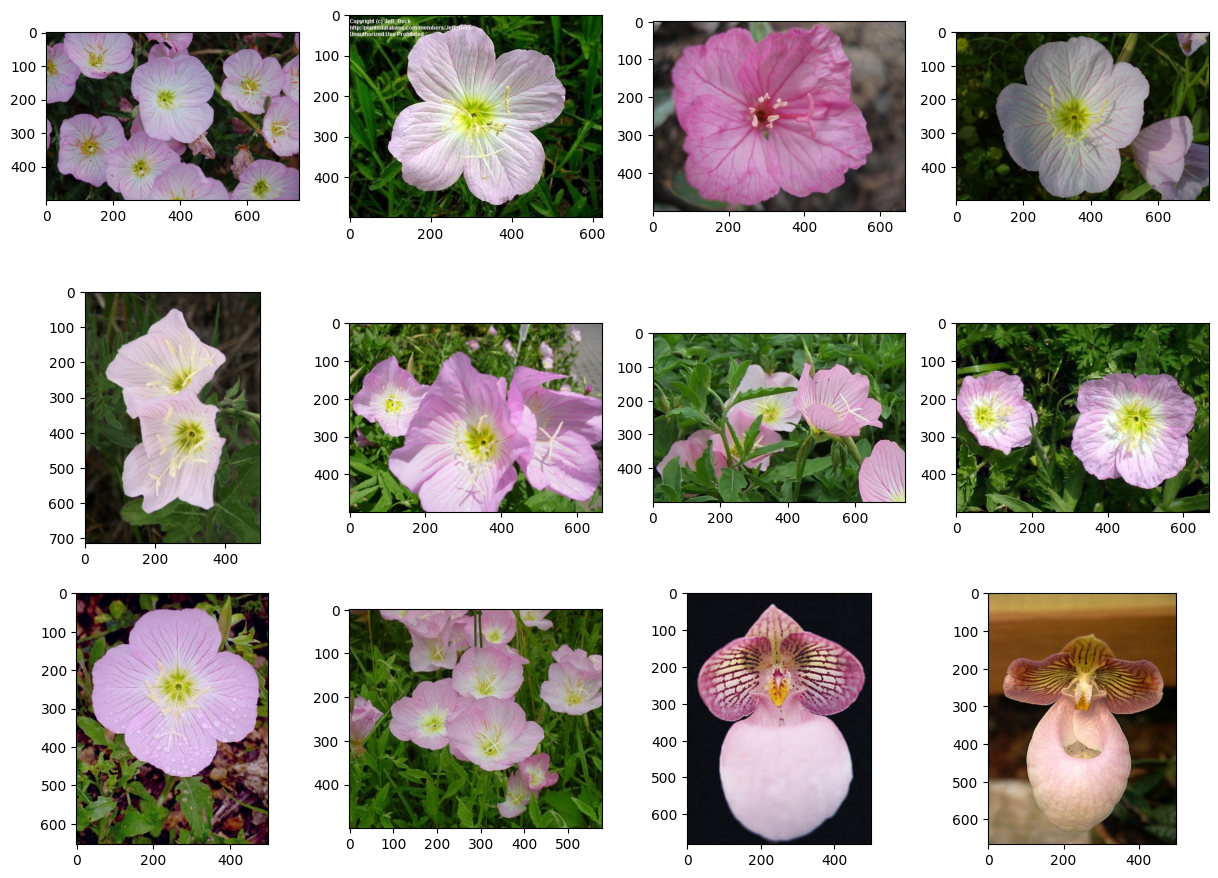

In [10]:
def show_image(dataset, n=12, cols=4):
    """Plots some sample from the dataset"""
    plt.figure(figsize=(15,15))
    for i, img in enumerate(dataset):
        if i == n:
            break
        plt.subplot(int(n/cols)+1, cols, i+1)
        plt.imshow(img[0])
        
data = torchvision.datasets.Flowers102(root="data", download=True)
show_image(data)

# 2. The Diffusion Model

## 2.1 Foward Process

In [11]:
def linear_beta_scheduler(timesteps, start=0.0001, end=0.008):
    return torch.linspace(start, end, timesteps)

def cosine_beta_scheduler(timesteps, start=0.0001, end=0.0025):
    t = torch.linspace(0, math.pi, timesteps)
    cos_values = torch.cos(t)
    betas = start + 0.5 * (end - start) * (1 + cos_values)
    return betas

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, scheduler="linear", device="cpu"):
    """ 
    Takes an image, a timestep and a noise scheduler as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    '''
    if (t.numpy() == 0).all():
        return x_0, noise
        '''
    
    if(scheduler == "cosine"):
        sqrt_alphas_cumprod_t = get_index_from_list(cosine_sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
            cosine_sqrt_one_minus_alphas_cumprod, t, x_0.shape
        )
        # mean + variance
        return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
        + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)
    
    elif(scheduler == "linear"):
        sqrt_alphas_cumprod_t = get_index_from_list(linear_sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
            linear_sqrt_one_minus_alphas_cumprod, t, x_0.shape
        )
        # mean + variance
        return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
        + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)
    
    else:
        print("UNKNOW SCHEDULER ! ONLY 'linear' and 'cosine' are accepted.")
        return noise, noise


#Pre compute betas and alphas
T=300

linear_betas = linear_beta_scheduler(T)
linear_alphas = 1. - linear_betas
linear_alphas_cumprod = torch.cumprod(linear_alphas, axis=0)
linear_sqrt_alphas_cumprod = torch.sqrt(linear_alphas_cumprod)
linear_sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - linear_alphas_cumprod)
linear_sqrt_recip_alphas = torch.sqrt(1.0 / linear_alphas)
linear_alphas_cumprod_prev = F.pad(linear_alphas_cumprod[:-1], (1, 0), value=1.0)
linear_posterior_variance = linear_betas * (1. - linear_alphas_cumprod_prev) / (1. - linear_alphas_cumprod)

cosine_betas = cosine_beta_scheduler(T)
cosine_alphas = 1. - cosine_betas
cosine_alphas_cumprod = torch.cumprod(cosine_alphas, axis=0)
cosine_sqrt_alphas_cumprod = torch.sqrt(cosine_alphas_cumprod)
cosine_sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - cosine_alphas_cumprod)
cosine_sqrt_recip_alphas = torch.sqrt(1.0 / cosine_alphas)
cosine_alphas_cumprod_prev = F.pad(cosine_alphas_cumprod[:-1], (1, 0), value=1.0)
cosine_posterior_variance = cosine_betas * (1. - cosine_alphas_cumprod_prev) / (1. - cosine_alphas_cumprod)


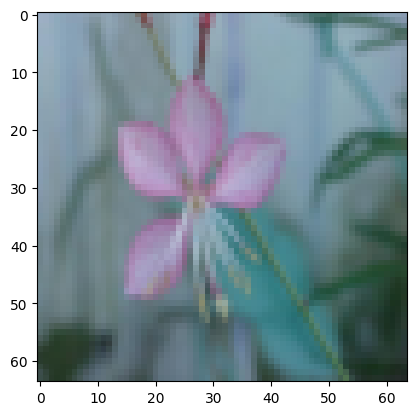

In [12]:
IMG_SIZE = 64
BATCH_SIZE = 128


def transform_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t*2)-1)
    ]
    data_transform = transforms.Compose(data_transforms)
    
    train = torchvision.datasets.Flowers102(root="data", download=True, transform=data_transform)
    test = torchvision.datasets.Flowers102(root="data", download=True,transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))
    
data = transform_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

image = next(iter(dataloader))[0]
show_tensor_image(image)

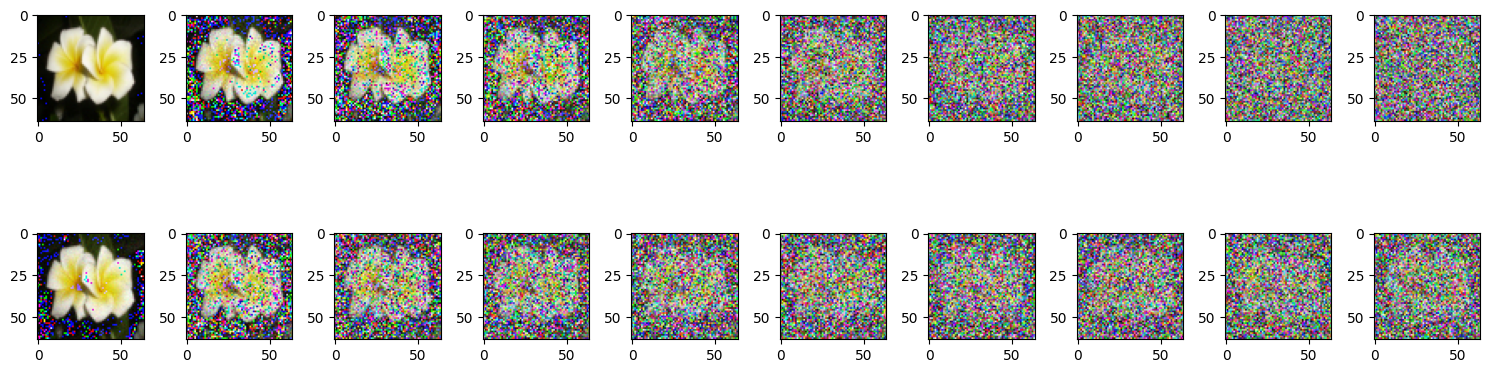

In [13]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,5))
num_images = 10
stepsize = int(T/num_images)


for sch in ["linear", "cosine"]:
    for idx in range(0, T, stepsize):
            t = torch.Tensor([idx]).type(torch.int64)
            if sch == "linear":
                plt.subplot(2, num_images, int(idx/stepsize) + 1)
            else:
                plt.subplot(2, num_images, int(idx / stepsize) + num_images + 1)
            img, noise = forward_diffusion_sample(image, t, scheduler=sch)
            show_tensor_image(img)
            
plt.tight_layout()



## 2.2 Backward process (Neural Network)

In [14]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch) #the time emb need to be the same size than the current number of channels
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

In [15]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [16]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

## 2.3 Loss 

In [17]:
def get_loss(model, x_0, t, scheduler):
    x_noisy, noise = forward_diffusion_sample(x_0, t, scheduler=scheduler, device=device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## 2.4 Sampling

In [18]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(linear_betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        linear_sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(linear_sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(linear_posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

## 2.4 Training

Epoch 0 | step 000 Loss: 0.8112868070602417 


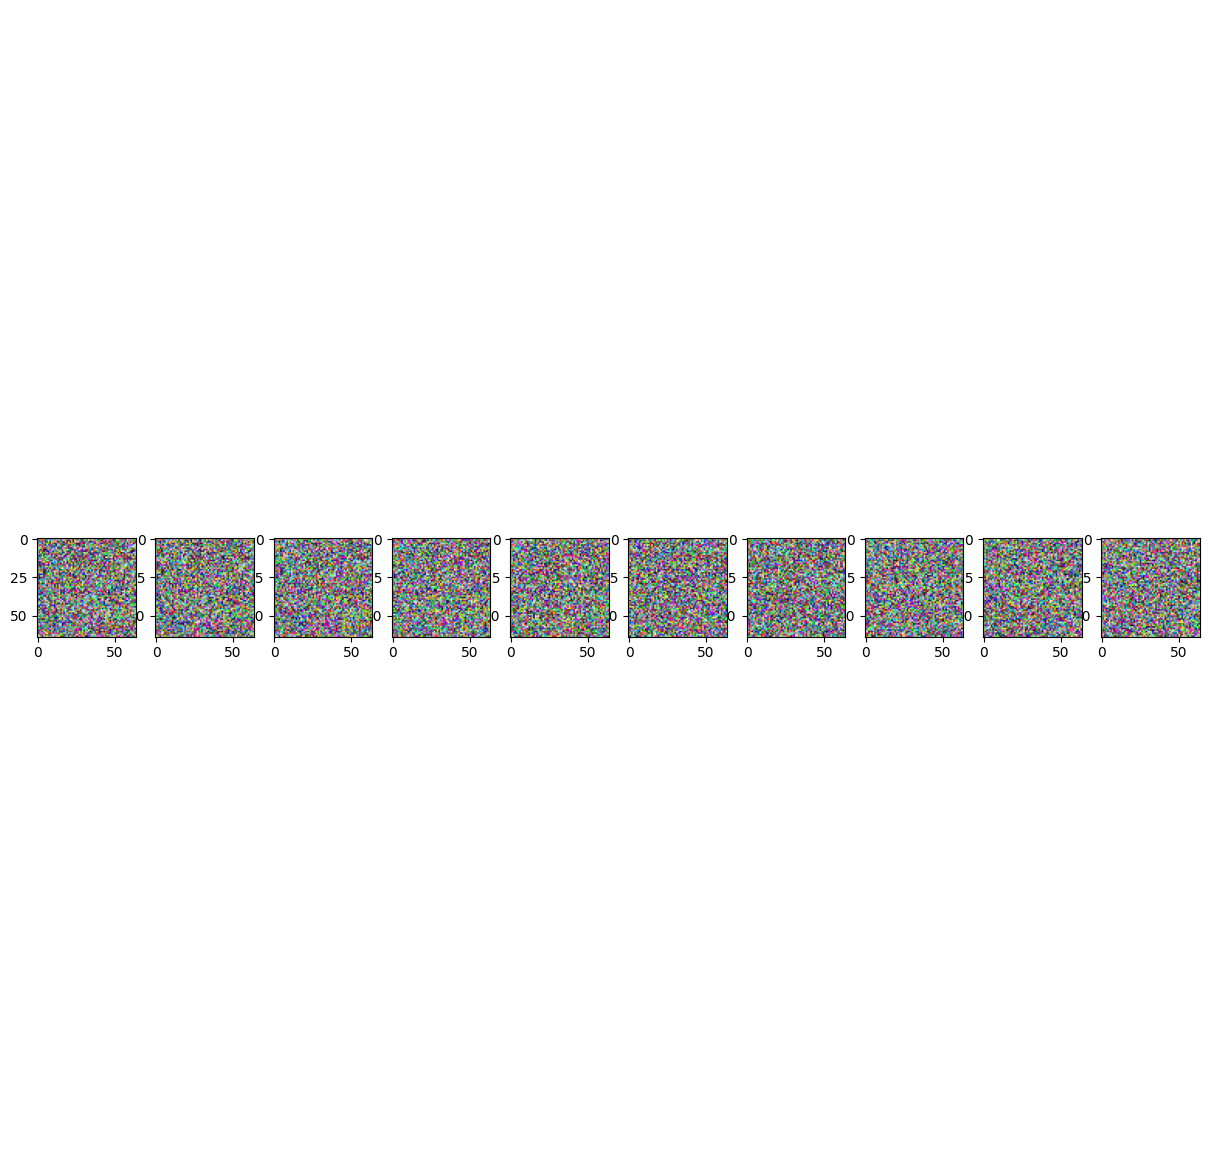

KeyboardInterrupt: 

In [19]:
%%time
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.01)
noise_scheduler = "linear" 
epochs = 100 

for epoch in range(epochs):
    
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t, noise_scheduler)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

In [ ]:
def save_model(model):
    torch.save(model.state_dict(), "./model.pth")

In [ ]:
def load_model(model):
    model.load_state_dict(torch.load("./model.pth"))

# 3. Results

## 3.1 Visual Results

In [ ]:
@torch.no_grad()
def generate_image(noise):
    """
    Generate one image from random noise using the trained Unet
    """
    image = noise
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        image = sample_timestep(image, t)
        if i == 0:
            return image
        

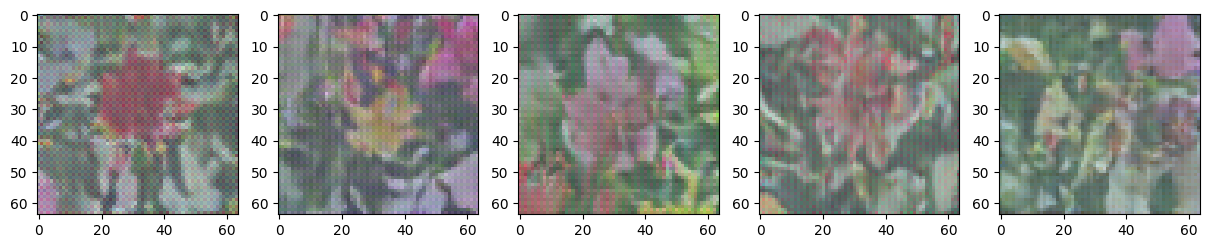

In [ ]:
n = 5
plt.figure(figsize=(15,15))
plt.axis('off')
for i in range(0,n):
    noise = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
    image = generate_image(noise)
    plt.subplot(1, n, i+1)
    show_tensor_image(image.detach().cpu())
plt.show()    